# Load Data

In [1]:
import numpy as np
import csv
import io
from os import mkdir
import json
import datetime
import pandas as pd 
import pickle
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
import lightgbm as lgb
import matplotlib.pyplot as plt
from util.plot_funcs import *
from random import uniform
from imblearn.over_sampling import RandomOverSampler
%load_ext autoreload
%autoreload 2
import warnings
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
warnings.filterwarnings('ignore')

/Users/shiwang/Desktop/Personal/test_API/env/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
train_queries = pd.read_csv('./data_set_phase1/train_queries.csv')
train_plans = pd.read_csv('./data_set_phase1/train_plans.csv')
train_clicks = pd.read_csv('./data_set_phase1/train_clicks.csv')
test_queries = pd.read_csv('./data_set_phase1/test_queries.csv')
test_plans = pd.read_csv('./data_set_phase1/test_plans.csv')
profiles = pd.read_csv('./data_set_phase1/profiles.csv')

In [3]:
train_clicks.head(3)

,sid,click_time,click_mode
0,2848914,2018-11-17 18:42:17,1
1,2629085,2018-10-12 16:28:13,3
2,602598,2018-11-11 16:38:42,2


In [4]:
profiles.head(3)

,pid,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,p21,p22,p23,p24,p25,p26,p27,p28,p29,p30,p31,p32,p33,p34,p35,p36,p37,p38,p39,p40,p41,p42,p43,p44,p45,p46,p47,p48,p49,p50,p51,p52,p53,p54,p55,p56,p57,p58,p59,p60,p61,p62,p63,p64,p65
0,196356,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,204083,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,170667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [5]:
train_queries.head(3)

,sid,pid,req_time,o,d
0,3000821,NaN,2018-11-02 17:54:30,"116.29,39.97","116.32,39.96"
1,3085857,210736.0,2018-11-16 10:53:10,"116.39,39.84","116.33,39.79"
2,2944522,NaN,2018-10-06 10:33:58,"116.31,39.93","116.27,40.00"


In [6]:
train_plans.head(3)

,sid,plan_time,plans
0,1709112,2018-11-04 11:45:04,"[{""distance"": 32303, ""price"": 600, ""eta"": 5087..."
1,3327773,2018-10-16 19:09:29,"[{""distance"": 3427, ""price"": 300, ""eta"": 627, ..."
2,3285959,2018-11-25 15:05:22,"[{""distance"": 36234, ""price"": 1100, ""eta"": 931..."


In [7]:
with open('./data_set_phase1/weather.json', 'r') as f:
    weather_dict = json.load(f)

# Pre-processing

In [18]:
output = []
for k,v in weather_dict.items():
    output.append(['2018-' + k, int(v['max_temp']), int(v['min_temp']), v['weather'], int(v['wind'])])
weather = pd.DataFrame(output, columns = ['date', 'max_temp', 'min_temp', 'weather', 'wind'])
weather['date'] = pd.to_datetime(weather['date']).apply(lambda x:x.date())

In [19]:
def pre_process_queries(X):
    X['pid'] = X['pid'].fillna(0)
    X['req_time'] = pd.to_datetime(X['req_time'])
    X['dow'] = X['req_time'].apply(lambda x: x.weekday())
    X['hr'] = X['req_time'].apply(lambda x: x.hour)
    X['O_lon'] = X['o'].apply(lambda x: float(x.split(',')[0]))
    X['O_lat'] = X['o'].apply(lambda x: float(x.split(',')[1]))
    X['D_lon'] = X['d'].apply(lambda x: float(x.split(',')[0]))
    X['D_lat'] = X['d'].apply(lambda x: float(x.split(',')[1]))
    
    X['date'] =  X['req_time'].apply(lambda x:x.date())
    X = X.merge(weather, on = 'date')
    
    del X['o']
    del X['d']
    del X['req_time']
    
    return X

In [10]:
%%time
train_queries = pre_process_queries(train_queries)
test_queries = pre_process_queries(test_queries)

CPU times: user 5.75 s, sys: 160 ms, total: 5.91 s
Wall time: 5.91 s


In [11]:
def pre_process_plan(X):
    try:
        X['plans'] = X['plans'].apply(lambda x: eval(x))
    except:
        pass
    
    outputs = []
    for _, row in X.iterrows():
        sid = row['sid']
        rank = 0
        for plan in row['plans']:
            outputs.append([sid, 
                            plan['distance'], 
                            plan['price'], 
                            plan['eta'], 
                            plan['transport_mode'],
                            rank])
            rank += 1
    
    output = pd.DataFrame(outputs, columns = ['sid','distance', 'price', 'eta','transport_mode', 'rank'])  
    output['price'] = output['price'].replace('',-1)
    output['distance'] = output['distance'].replace('',-1)
    output['eta'] = output['eta'].replace('',-1)
    return output

In [12]:
%%time
train_plans_ = pre_process_plan(train_plans)
test_plans_  = pre_process_plan(test_plans)

CPU times: user 1min 33s, sys: 1.11 s, total: 1min 34s
Wall time: 1min 34s


In [13]:
train_plans_.drop_duplicates(subset = ['sid','transport_mode'], inplace=True)
test_plans_.drop_duplicates(subset = ['sid','transport_mode'], inplace=True)

In [14]:
%%time
profiles['profile'] = profiles.apply(lambda row: [x + 1 for x in range(66) if row['p'+str(x)] == 1], axis = 1)
profiles = profiles.append({'pid' : 0 , 'profile' : []} , ignore_index=True).fillna(0)

CPU times: user 28.9 s, sys: 56.5 ms, total: 29 s
Wall time: 29 s


In [15]:
train_clicks = train_clicks[['sid','click_mode']]
train_clicks['label'] = 1

# Merge

In [16]:
train = train_plans_.merge(train_queries, on ='sid')\
            .merge(profiles, on = 'pid')\
            .merge(train_clicks[['sid']], on = 'sid')\
            .merge(train_clicks, left_on = ['sid', 'transport_mode'], 
                   right_on = ['sid', 'click_mode'], how = 'left')
del train['click_mode']
train['label'] = train['label'].fillna(0)

In [17]:
test = test_plans_.merge(test_queries, on ='sid')\
            .merge(profiles, on = 'pid')

# Exploration

## Clicked Transport Mode

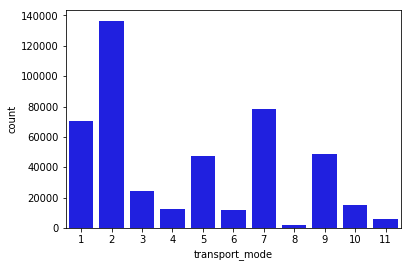

In [18]:
sns.countplot(train[train['label'] == 1]['transport_mode'], color = 'blue')

## Number of plans

In [ ]:
sns.countplot(train['num_plans'], color = 'blue')

In [ ]:
sns.countplot(test['num_plans'], color = 'blue')

## Click Rank for Multiple Plan Session

In [ ]:
sns.countplot(train[(train['label'] == 1) & (train['num_plans'] > 1)]['rank'], color = 'blue')

## Distributions

In [ ]:
train[['eta','distance', 'price', 'O_lon','O_lat', 'D_lon', 'D_lat']].quantile([0, .05, .25, .50, .75, .95, 1])

In [ ]:
sns.countplot(train['dow'], color = 'blue')

In [ ]:
sns.countplot(train['hr'], color = 'blue')

# Feature Engineering

In [20]:
def add_direction(df):
    df['lon_diff'] = df['O_lon'] - df['D_lon']
    df['lat_diff'] = df['O_lat'] - df['D_lat']
    return df

In [21]:
%%time
train = add_direction(train)
test = add_direction(test)

CPU times: user 68.4 ms, sys: 15.7 ms, total: 84 ms
Wall time: 41.4 ms


In [22]:
def add_time_stats(df):
    for col in ['hr','dow']:
        colname = 'mode_'+col+'_clicks'
        subset = train[(train['label'] == 1)]
        temp_1 = subset.groupby( [col], as_index = False).agg({'sid':len}).rename(columns = {'sid':col+'_clicks'})
        temp_2 = subset.groupby( [col, 'transport_mode'], as_index = False)\
                .agg({'sid':len}).rename(columns = {'sid':colname})
        temp = temp_1.merge(temp_2, on = col)
        temp[colname] = temp[colname] / temp[col+'_clicks']
        temp[colname] = temp[colname].fillna(0)
        del temp[col+'_clicks']
        df = df.merge(temp, on = ['transport_mode', col], how = 'left')
    return df

In [24]:
%%time
train = add_time_stats(train)
test = add_time_stats(test)

CPU times: user 6.74 s, sys: 5.63 s, total: 12.4 s
Wall time: 12.4 s


In [25]:
def add_num_plans(df):
    num_plans = df.groupby(['sid'], as_index = False)['rank'].agg({'num_plans':lambda x: max(x) + 1})
    df = df.merge(num_plans, how = 'left', on = 'sid')
    return df

In [26]:
%%time
train = add_num_plans(train)
test = add_num_plans(test)

CPU times: user 10.8 s, sys: 3.19 s, total: 14 s
Wall time: 14 s


In [28]:
def add_dummy(df, col, prefix):
    temp = pd.get_dummies(df[col], prefix=prefix)
    df = pd.concat([df, temp], axis = 1)
    return df

In [29]:
%%time
train = add_dummy(train, 'weather', 'weather')
test = add_dummy(test, 'weather', 'weather')

CPU times: user 2.01 s, sys: 1.66 s, total: 3.67 s
Wall time: 3.67 s


In [ ]:
%%time
train = add_dummy(train, 'weather', 'weather')
test = add_dummy(test, 'weather', 'weather')

In [1645]:
%%time
train = add_dummy(train, 'transport_mode', 'mode')
test = add_dummy(test, 'transport_mode', 'mode')

CPU times: user 998 ms, sys: 810 ms, total: 1.81 s
Wall time: 1.81 s


In [30]:
def add_max_min(df):
    cols = ['eta','distance','price']
    temp_columns = ['sid'] + [x + '_' + y for x in cols for y in ['min', 'max']]
    temp = df.groupby('sid', as_index = False).agg({'eta':[min, max], 'distance':[min, max], 'price':[min, max]})
    temp.columns = temp.columns.droplevel()
    temp.columns = temp_columns
    
    df = df.merge(temp, on = 'sid')
    for col in cols:
        for t in ['max', 'min']:
            df[col + '_' + t] = df[col] == df[col + '_' + t]
    
    return df

In [31]:
%%time
train = add_max_min(train)
test = add_max_min(test)

CPU times: user 5.76 s, sys: 4.59 s, total: 10.3 s
Wall time: 10.3 s


In [1256]:
def add_avg_diff(df):
    cols = ['eta','distance','price']
    temp_columns = ['sid'] + [x + '_avg_diff' for x in cols]
    temp = df.groupby('sid', as_index = False).agg({'eta':np.mean, 'distance':np.mean, 'price':np.mean})
    temp.columns = temp_columns
    
    df = df.merge(temp, on = 'sid')
    for col in cols:
        avg = df[col + '_avg_diff']
        df[col + '_avg_diff'] = df[col] - avg
        df[col + '_avg_diff_per'] = (df[col] - avg) / (avg + 0.001)
    
    return df

In [33]:
%%time
train = add_avg_diff(train)
test = add_avg_diff(test)

CPU times: user 5.16 s, sys: 4.4 s, total: 9.57 s
Wall time: 9.23 s


In [34]:
def add_other_modes(df):
    temp = df.groupby('sid', as_index=False)['transport_mode']\
            .agg({'mode_list_from_0':lambda x: [xx for xx in x]})
    df = df.merge(temp, on = 'sid')
    temp = df.groupby('sid', as_index=False)['transport_mode']\
            .agg({'mode_list':lambda x: ','.join(sorted(x.astype(str), key = lambda x:int(x)))})
    df = df.merge(temp, on = 'sid')
    output = []
    for this_mode, all_modes in zip(df['transport_mode'], df['mode_list_from_0']):
        other_modes = [x for x in all_modes if x != this_mode]
        temp = [0] * 11
        for other_mode in other_modes:
            temp[other_mode - 1] = 1
        output.append(temp)
        
    output = pd.DataFrame(output, columns = ['other_mode_' + str(i) for i in range(1,12)])
    df = pd.concat([df, output], axis = 1)
    return df

In [35]:
%%time
train = add_other_modes(train)
test = add_other_modes(test)

CPU times: user 2min 40s, sys: 12.9 s, total: 2min 53s
Wall time: 2min 53s


In [36]:
def add_mode_clicks(df):
    temp = pd.DataFrame(train[(train['label'] == 1)]['transport_mode'].value_counts().reset_index())
    temp.columns = ['transport_mode', 'num_clicks']
    temp['mode_per_click'] = temp['num_clicks'] / sum(temp['num_clicks']) * 100
    del temp['num_clicks']
    df = df.merge(temp, on = 'transport_mode')
    return df

In [37]:
%%time
train = add_mode_clicks(train)
test = add_mode_clicks(test)

CPU times: user 12.4 s, sys: 6.87 s, total: 19.2 s
Wall time: 19.2 s


In [38]:
def add_rank_mode_clicks(df):
    subset = train[(train['label'] == 1) & (train['num_plans'] > 1)]
    temp_1 = subset.groupby( ['rank'], as_index = False).agg({'sid':len}).rename(columns = {'sid':'rank_clicks'})
    temp_2 = subset.groupby( ['rank', 'transport_mode'], as_index = False)\
            .agg({'sid':len}).rename(columns = {'sid':'mode_rank_clicks'})
    temp = temp_1.merge(temp_2, on = 'rank')
    temp['mode_rank_clicks'] = temp['mode_rank_clicks'] / temp['rank_clicks']
    temp['mode_rank_clicks'] = temp['mode_rank_clicks'].fillna(0)
    del temp['rank_clicks']
    df = df.merge(temp, on = ['transport_mode', 'rank'], how = 'left')
    return df

In [39]:
%%time
train = add_rank_mode_clicks(train)
test = add_rank_mode_clicks(test)

CPU times: user 7.83 s, sys: 5.8 s, total: 13.6 s
Wall time: 13.6 s


In [40]:
def add_mode_rank_per_click(df):
    temp = train[(train['num_plans'] > 1)].groupby( ['rank', 'transport_mode'], as_index = False)\
        .agg({'label':np.mean}).rename(columns = {'label':'mode_rank_per_click'})
    df = df.merge(temp, on = ['transport_mode', 'rank'], how = 'left')
    return df

In [41]:
%%time
train = add_mode_rank_per_click(train)
test = add_mode_rank_per_click(test)

CPU times: user 9.19 s, sys: 6.71 s, total: 15.9 s
Wall time: 15.9 s


In [1995]:
def add_weight(df, add_weight = False):
    if add_weight == False:
        return df
    else:
        temp = pd.DataFrame(train[(train['label'] == 1)]['transport_mode'].value_counts()).reset_index().sort_values(by = 'index')
        temp.columns = ['transport_mode', 'weight']
        temp['weight'] = np.sqrt(1 / temp['weight'] * 10000)
        temp.loc[temp['transport_mode'] == 3, 'weight'] = temp.loc[temp['transport_mode'] == 3, 'weight'] * 3
        #temp.loc[temp['transport_mode'] == 3, 'weight'] = temp.loc[temp['transport_mode'] == 4, 'weight'] * 3
        #temp.loc[temp['transport_mode'] == 3, 'weight'] = temp.loc[temp['transport_mode'] == 9, 'weight'] * 2
        temp = temp.merge(train[train['label'] == 1][['sid','transport_mode']], on = 'transport_mode')[['sid','weight']]
        temp['label'] = 1
        df = df.merge(temp, on = ['sid','label'], how = 'left')
        df['weight'] = df['weight'].fillna(1)
        return df

In [492]:
def add_weight(df, add_weight = False):
    if add_weight == False:
        return df
    else:
        temp = train.groupby(['transport_mode'], as_index = False)['label'].agg({'count':len, 'positive':sum})
        temp['weight'] = 2 * (temp['count'] - temp['positive']) / temp['positive']
        temp['label'] = 1
        del temp['count']
        del temp['positive']
        df = df.merge(temp, on = ['transport_mode','label'], how = 'left')
        df['weight'] = df['weight'].fillna(1)
        return df

In [1379]:
def add_weight(df, add_weight = False):
    if add_weight == False:
        return df
    else:
        df['weight'] = 1
        df.loc[(df['label'] == 1) & (df['transport_mode']== 3),'weight'] = 5
        df.loc[(df['label'] == 1) & (df['transport_mode']== 2),'weight'] = 0.5
        df.loc[(df['label'] == 0) & (df['transport_mode']== 2),'weight'] = 3
        df.loc[(df['label'] == 1) & (df['transport_mode']== 7),'weight'] = 0.5
        df.loc[(df['label'] == 1) & (df['transport_mode']== 4),'weight'] = 3
        df.loc[(df['label'] == 1) & (df['transport_mode']== 6),'weight'] = 3
        df.loc[(df['label'] == 1) & (df['transport_mode']== 9),'weight'] = 5
        return df

In [1996]:
if 'weight' in train.columns:
    del train['weight']

In [1997]:
%%time
train = add_weight(train, add_weight=True)

CPU times: user 8.25 s, sys: 4.66 s, total: 12.9 s
Wall time: 12.9 s


In [1341]:
def add_mode_list_mode_click(df):
    temp   = train[(train['label'] == 1)][['sid','transport_mode', 'mode_list']]
    temp_3 = temp.groupby(['mode_list'], as_index=False)['sid'].agg({'tot_clicks':len})
    temp_4 = temp.groupby(['mode_list','transport_mode'], as_index=False)['sid']\
                .agg({'mode_list_mode_click':len})
    output = temp_3.merge(temp_4, on = 'mode_list')
    output['mode_list_mode_click'] = output['mode_list_mode_click'] / output['tot_clicks']
    df = df.merge(output, on = ['mode_list', 'transport_mode'])
    return df

In [1342]:
%%time
train = add_mode_list_mode_click(train)
test = add_mode_list_mode_click(test)

CPU times: user 12.6 s, sys: 9.09 s, total: 21.7 s
Wall time: 21.7 s


In [1343]:
def add_all_min(df):
    df['all_min'] = (df['eta_avg_diff']<0).astype(int) + (df['distance_avg_diff']<0).astype(int) + (df['price_avg_diff']<0).astype(int)
    return df

In [48]:
%%time
train = add_all_min(train)
test = add_all_min(test)

CPU times: user 56.9 ms, sys: 7.38 ms, total: 64.3 ms
Wall time: 31.5 ms


In [1859]:
def add_divide(df):
    df['eta_per_distance'] = df['eta'] / (df['distance'] + 0.001)
    df['price_per_distance'] = df['price'] / (df['distance'] + 0.001)
    df['price_per_eta'] = df['price'] / (df['eta'] + 0.001)
    
    temp = df.groupby('transport_mode', as_index = 'False').agg({'eta_per_distance':np.mean,
                                                                    'price_per_distance':np.mean,
                                                                    'price_per_eta':np.mean}).reset_index()
    temp.columns  = ['transport_mode', 'eta_dis_avg','price_dis_avg','price_eta_avg']
    
    df = df.merge(temp, on = 'transport_mode')
    df['eta_per_distance'] = df['eta_per_distance'] - df['eta_dis_avg']
    df['price_per_distance'] = df['price_per_distance'] - df['price_dis_avg']
    df['price_per_eta'] = df['price_per_eta'] - df['price_eta_avg']
                           
    del df['eta_dis_avg']                                                     
    del df['price_dis_avg']
    del df['price_eta_avg']
    return df

In [1860]:
%%time
train = add_divide(train)
test = add_divide(test)

CPU times: user 7.63 s, sys: 6.47 s, total: 14.1 s
Wall time: 13.8 s


In [883]:
train['price_NA'] = train['price'] == -1
test['price_NA'] = test['price'] == -1

In [1433]:
def add_time(df):
    df['is_night'] = df['hr'].isin([23,0,1,2,3,4,5])
    df['is_weekend'] = df['dow'].isin([4,5])
    return df

In [1434]:
%%time
train = add_time(train)
test = add_time(test)

CPU times: user 27.7 ms, sys: 884 µs, total: 28.6 ms
Wall time: 27.7 ms


# Save intermediate data to pickle

In [1998]:
%%time
data = {'train': train, 'test':test, 'all_test_sid':set(test_queries['sid'])}
with open('./processed_data/data.pickle', 'wb') as handle:
    pickle.dump(data, handle)

CPU times: user 2.97 s, sys: 1.54 s, total: 4.51 s
Wall time: 4.85 s


In [1999]:
%%time
with open('./processed_data/data.pickle', 'rb') as handle:
    data = pickle.load(handle)

train = data['train']
test = data['test']

CPU times: user 1.54 s, sys: 1.86 s, total: 3.4 s
Wall time: 3.4 s


# Scale/Standardize

In [2000]:
train_ = train[(train['num_plans'] > 1)]
test_ = test.copy()

In [2001]:
continuous_features = [
 'price_avg_diff',
 'price_avg_diff_per',
 'eta_per_distance',
 'price_per_distance',
 'price_per_eta',
 'eta_avg_diff',
 'eta_avg_diff_per',
 'distance_avg_diff',
 'distance_avg_diff_per',
 'O_lon',
 'O_lat',
 'D_lat',
 'D_lon',
 'lat_diff',
 'lon_diff'
]

In [1865]:
for col in continuous_features:
    data = pd.concat([train_[col], test_[col]])
    data = data[(data < data.quantile(.95)) & (data > data.quantile(.05))]
    mean_ = data.mean()
    std_  = data.std()
    train_[col] = np.minimum(mean_ + 3 * std_, train_[col])
    train_[col] = np.maximum(mean_ - 3 * std_, train_[col])
    test_[col]  = np.minimum(mean_ + 3 * std_, test_[col])
    test_[col]  = np.maximum(mean_ - 3 * std_, test_[col])
    print(col, mean_, std_)

price_avg_diff -213.96073768060643 1504.3676506530935
price_avg_diff_per -1.1051251617994144 1.2903448333471232
eta_per_distance -0.3604407633620088 0.8556338678943897
price_per_distance -10.54305936902242 27.721991364400033
price_per_eta -1.0744730330018974 2.7653061851593463
eta_avg_diff -26.25954571768727 739.8777191176094
eta_avg_diff_per -0.4756775976184652 6.27371396960742
distance_avg_diff -54.598561682182556 1023.9481207687788
distance_avg_diff_per -2.5791468239526583 29.756440082779378
O_lon 116.38354296405443 0.07391321544893589
O_lat 39.93695284944339 0.06283527059547236
D_lat 39.9364300017024 0.06166410588138646
D_lon 116.38280717294954 0.07418815778996804
lat_diff -0.0008574475124226891 0.0652846050789256
lon_diff 0.0014577024509894877 0.0800510727122792


# Baseline LGB model

## Train/Validation Split

In [2002]:
exclude_columns = ['sid','pid','profile',
                   'transport_mode','label','weight','tot_clicks',
                   'mode_list','mode_list_from_0','weather_xq', 
                   'weather','date', 'weather_xq', 'weather_xydy',
                    #'price_avg_diff_per',
                    # 'eta_avg_diff_per',
                    # 'distance_avg_diff_per',
                   'mode_list_mode_click',
                    #'eta_per_distance',
                    #'price_per_distance',
                    #'price_per_eta',
                   #'mode_rank_per_click',
                   #'mode_rank_clicks',
                   #'rank',
                   #'mode_per_click'
                   #'eta','distance','price'
                  ] 
features = [x for x in train_.columns if x not in exclude_columns]

In [2003]:
sid_train = list(set(train_[train_['date'] <  datetime.date(2018, 11, 24)]['sid']))
sid_eval  = list(set(train_[train_['date'] >= datetime.date(2018, 11, 24)]['sid']))

In [1867]:
sid_train, sid_eval = train_test_split(list(set(train_['sid'])),
                                       test_size = 0.15, 
                                       random_state = 88)

In [2004]:
T = train_[train_['sid'].isin(sid_train)]
V = train_[train_['sid'].isin(sid_eval)]

In [2005]:
X_train = T
X_eval  = V
y_train = T['label']
y_eval  = V['label']

## Model Training

In [2006]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_seed':0,
    'bagging_freq': 1,
    'verbose': 1,
    #'reg_alpha':1,
    #'reg_lambda':1
}

In [2007]:
lgb_train = lgb.Dataset(X_train[features], y_train, weight = X_train['weight'])
lgb_evals = lgb.Dataset(X_eval[features], y_eval, reference = lgb_train)

In [2008]:
%%time
gbm_all = lgb.train(params,
                lgb_train,
                num_boost_round = 3000,
                valid_sets =[ lgb_train,lgb_evals],
                valid_names = ['train','valid'],
                early_stopping_rounds = 100,
                verbose_eval = 300
                )

Training until validation scores don't improve for 100 rounds.
[300]	train's auc: 0.883092	valid's auc: 0.915589
[600]	train's auc: 0.891107	valid's auc: 0.916465
[900]	train's auc: 0.897642	valid's auc: 0.916943
[1200]	train's auc: 0.903823	valid's auc: 0.917232
Early stopping, best iteration is:
[1109]	train's auc: 0.901932	valid's auc: 0.917332
CPU times: user 41min 45s, sys: 1min 13s, total: 42min 58s
Wall time: 4min 7s


In [2022]:
feature_importance = sorted([(x,y) for x, y in zip(gbm_all.feature_name(), gbm_all.feature_importance())],
                            key = lambda x: x[1], reverse=True)

In [334]:
top_features = [x for x, y in feature_importance][:50]

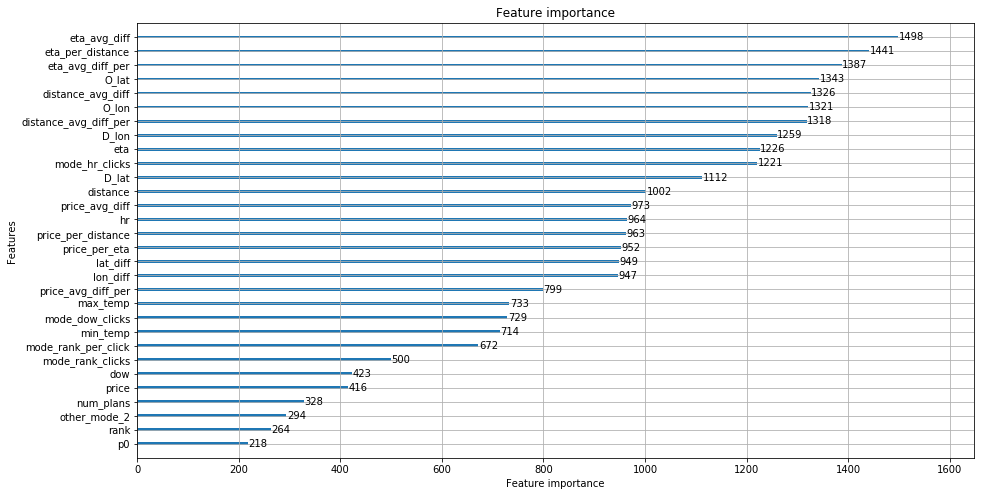

In [2023]:
lgb.plot_importance(gbm_all, figsize=(15,8), max_num_features = 30)

**Generate predictions**

In [2011]:
def get_best_mode_dt(gp):
    result = [(x, y) for x, y in zip(gp['transport_mode'], gp['pred_prob'])]
    result.sort(key = lambda x: x[1], reverse = True)
    return result[0][0]

In [2012]:
def get_predictions_lgb(df, gbm, features):
    pred = gbm.predict(df[features])
    df['pred_prob'] = pred
    output = pd.DataFrame(df.groupby('sid').apply(get_best_mode_dt)).reset_index()
    output.columns = ['sid', 'recommend_mode']
    return df, output 

## Apply to validation set

In [2013]:
X_eval, output = get_predictions_lgb(X_eval, gbm_all, features)

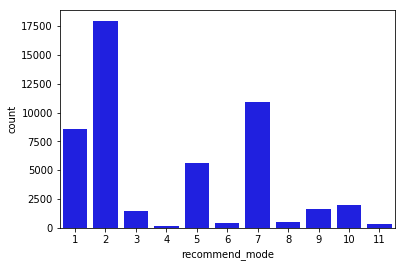

In [2014]:
sns.countplot(output['recommend_mode'], color = 'blue')

In [2015]:
eval_true = X_eval[X_eval['label'] == 1][['sid','transport_mode']]
eval_true.columns = ['sid','true']
output.columns = ['sid', 'pred']
eval_sum = eval_true.merge(output, on = 'sid')\

In [2016]:
weight_f1 = f1_score(eval_sum['true'], eval_sum['pred'], average = 'weighted')

In [2017]:
weight_f1 #0.745, 0.747, 0.748

0.7494839777320313

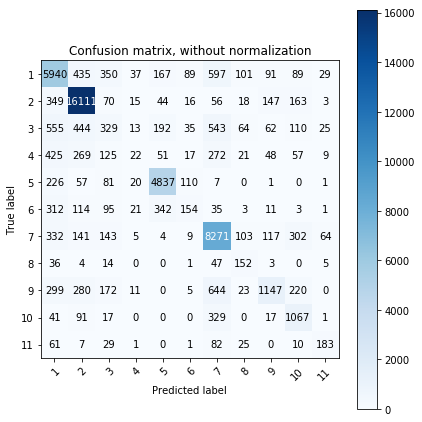

In [2018]:
plot_confusion_matrix_(eval_sum['true'], eval_sum['pred'], classes=list(range(1,12)))

## Apply to test set

In [2019]:
%%time
test_, output = get_predictions_lgb(test_, gbm_all, features)

CPU times: user 43.7 s, sys: 1.62 s, total: 45.3 s
Wall time: 16.6 s


In [900]:
%%time
data = {'gbm': gbm, 'features': features, 'train': train, 'test': test}
with open('./model/model_0501_692.pickle', 'wb') as handle:
    pickle.dump(data, handle)

CPU times: user 15.4 s, sys: 1.76 s, total: 17.2 s
Wall time: 14.1 s


**Fill no-plan sessions with zeros**

In [2024]:
set_1 = set(test_queries['sid'])
set_2 = set(test_['sid'])
no_click_sids = [x for x in set_1 if x not in set_2]
temp = pd.DataFrame({'sid': no_click_sids, 'recommend_mode':0})
output = pd.concat([output, temp], axis = 0, ignore_index=True)

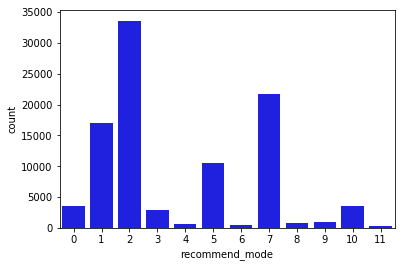

In [2025]:
sns.countplot(output['recommend_mode'], color = 'blue')

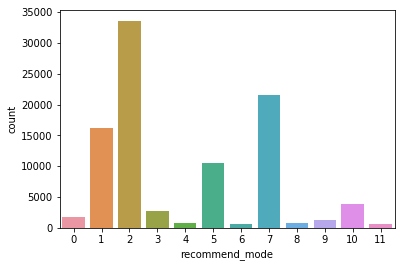

In [1296]:
sns.countplot(temp['recommend_mode'])

In [2026]:
def percent_counts(df):
    temp = df.value_counts().reset_index()
    temp.columns = ['mode','count']
    temp['count'] = temp['count'] / sum(temp['count'])
    display(temp)

In [2027]:
percent_counts(train[train['label'] == 1]['transport_mode'])

,mode,count
0,2,0.301081
1,7,0.172519
2,1,0.155225
3,9,0.107788
4,5,0.104735
5,3,0.054322
6,10,0.032828
7,4,0.027807
8,6,0.026168
9,11,0.013432


In [2028]:
percent_counts(output['recommend_mode'])

,mode,count
0,2,0.349526
1,7,0.225380
2,1,0.176978
3,5,0.109388
4,10,0.037742
5,0,0.037336
6,3,0.029817
7,9,0.010660
8,8,0.009017
9,4,0.006178


**Export csv**

In [2029]:
time_ = str(datetime.datetime.now())
mkdir('./submission/' + time_)

In [2030]:
output['sid'] = output['sid'].astype(str)
output['recommend_mode'] = output['recommend_mode'].astype(str)
output.to_csv('./submission/' + time_ + '/submission.csv', index = False, quoting = csv.QUOTE_NONNUMERIC)